In [ ]:
# WEEK 10

import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

# Loading the dataset
(X_train,y_train),(X_test,y_test)=mnist.load_data()

X_train.shape,y_train.shape,X_test.shape,y_test.shape

# Flattening each input image into a vector of length 784
X_train = X_train.reshape(X_train.shape[0],28*28)
X_test = X_test.reshape(X_test.shape[0],28*28)
#Normalizing
X_train = X_train /255
X_test = X_test /255


X_train.shape,X_test.shape

cv=ShuffleSplit(n_splits=10,test_size=0.2,random_state=42)

# function for training classifiers for MNIST multiclass classification problem

def train_classifiers(estimator,X_train,y_train,cv,name):
    estimator.fit(X_train,y_train)
    cv_train_score=cross_val_score(estimator,X_train,y_train,
                                  cv=cv,scoring='f1_macro')
    print(f"On an average {name} model has f1 score of {cv_train_score.mean():.3f} +/- {cv_train_score.std():.3f} on training set")

# Eval function takes estimator, test , feature matrix and labels as input and produce
# classification report and confusion matrix.
def eval(estimator,X_test,y_test):
    y_pred=estimator.predict(X_test)
    print("# Classification report")
    print(classification_report(y_test,y_pred))
    print("# Confusion matrix")
    disp=ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test,y_pred))
    disp.plot()
    plt.title("Confusion matrix")
    plt.show()

# Lets train 3 different classifiers
# Decision tree, Bagging Classifier, Random Forest Classifier

# Decision Tree for MNIST dataset

dt_pipeline=Pipeline([('classifier',DecisionTreeClassifier())])
train_classifiers(dt_pipeline,X_train,y_train.ravel(),cv,'decision tree')

eval(dt_pipeline,X_test,y_test)

# BAGGING CLASSIFIER ON MNIST
bag_pipeline=Pipeline([('classifier',BaggingClassifier())])
train_classifiers(bag_pipeline,X_train,y_train.ravel(),cv,'bagging')

eval(bag_pipeline,X_test,y_test)

# RANDOM FOREST CLASSIFIER ON MNIST
randomforest_pipeline=Pipeline([('classifier',RandomForestClassifier())])
train_classifiers(randomforest_pipeline,X_train,y_train.ravel(),cv,'random forest')

eval(randomforest_pipeline,X_test,y_test)

# Bagging and Random Forest Regressor on California Housing Dataset
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit

np.random.seed(306)

cv=ShuffleSplit(n_splits=10,test_size=0.2,random_state=42)

features,labels = fetch_california_housing(as_frame=True,
                                          return_X_y=True)
labels *= 100
com_train_features,test_features,com_train_labels,test_labels=train_test_split(
features,labels,random_state=42)
train_features,dev_features,train_labels,dev_labels=train_test_split(
com_train_features,com_train_labels,random_state=42)

def train_regressor(estimator,X_train,y_train,cv,name):
    cv_results=cross_validate(estimator,X_train,y_train,
                             cv=cv,scoring='neg_mean_absolute_error',return_train_score=True,
                             return_estimator=True)
    cv_train_error=-1*cv_results['train_score']
    cv_test_error = -1*cv_results['test_score']
    print(f"On an average {name} makes an error of "
         f"{cv_train_error.mean():.3f}k+/-{cv_train_error.std():.3f}k on train set.")
    print(f"On an average {name} makes an error of "
         f"{cv_test_error.mean():.3f}k+/-{cv_test_error.std():.3f}k on test set.")
    

train_regressor(DecisionTreeRegressor(),
               com_train_features,com_train_labels,cv,'decision tree regressor')


train_regressor(BaggingRegressor(),
               com_train_features,com_train_labels,cv,'bagging regressor')


train_regressor(RandomForestRegressor(),
               com_train_features,com_train_labels,cv,'random forest regressor')


# PARAMETRIC SEARCH OF RANDOM FOREST REGRESSOR
import pandas as pd
param_distribution={
    'n_estimators':[1,2,5,10,20,50,100,200,500],
    'max_leaf_nodes':[2,5,10,20,50,100],
}
search_cv=RandomizedSearchCV(
RandomForestRegressor(n_jobs=2),param_distributions=param_distribution,
                     scoring='neg_mean_absolute_error',n_iter=10,random_state=0,
                     n_jobs=2)
search_cv.fit(com_train_features,com_train_labels)
columns=[f"param_{name}" for name in param_distribution.keys()]
columns+=['mean_test_error','std_test_error']
cv_results=pd.DataFrame(search_cv.cv_results_)
cv_results['mean_test_error']=-cv_results['mean_test_score']
cv_results['std_test_error']=cv_results['std_test_score']
cv_results[columns].sort_values(by="mean_test_error")

error=-search_cv.score(test_features,test_labels)
print(f"On average, our random forest regressor makes an error of {error:.2f} k$")

# AdaBoost and GradientBoost on MNIST
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split,cross_validate,cross_val_score,ShuffleSplit
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.pipeline import Pipeline

(X_train,y_train),(X_test,y_test)=mnist.load_data()

X_train.shape,y_train.shape,X_test.shape,y_test.shape

X_train=X_train.reshape(X_train.shape[0],28*28)
X_test=X_test.reshape(X_test.shape[0],28*28)

X_train=X_train/255
X_test=X_test/255

cv=ShuffleSplit(n_splits=10,test_size=0.2,random_state=42)

def train_classifiers(estimator,X_train,y_train,cv,name):
    estimator.fit(X_train,y_train)
    cv_train_score=cross_val_score(estimator,X_train,y_train,
                                  cv=cv,scoring='f1_macro')
    print(f"On an average {name} model has f1 score of {cv_train_score.mean():.3f} +/- {cv_train_score.std():.3f} on training set")

def eval(estimator,X_test,y_test):
    y_pred=estimator.predict(X_test)
    print("# Classification report")
    print(classification_report(y_test,y_pred))
    print("# Confusion matrix")
    disp=ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test,y_pred))
    disp.plot()
    plt.title("Confusion matrix")
    plt.show()

# AdaBoostClassifer uses decision stumps as weak learners
# GradientBoostingClassifier uses decision trees as weak learners

# y_train[:10]

# from sklearn.ensemble import AdaBoostRegressor
abc_pipeline=Pipeline([('classifer',AdaBoostClassifier())])
train_classifiers(abc_pipeline,X_train,y_train.ravel(),cv,'AdaBoostClassifer')

eval(abc_pipeline,X_test,y_test)

# MNIST classification with GradientBoosting Classifier
gbc_pipeline=Pipeline([('classifier',GradientBoostingClassifier(n_estimators=10))])
train_classifiers(gbc_pipeline,X_train,y_train.ravel(),cv,'GradientBoostingClassifier')

eval(gbc_pipeline,X_test,y_test)

# MNIST CLASSIFICATION WITH XGBOOST Classifier

try:
    from xgboost import XGBClassifier
    print("Imported without installation")
except:
    !pip install xgboost
    from xgboost import XGBClassifier
    print("Downloaded and imported")

?XGBClassifier

xbc_pipeline=Pipeline([('classifier',XGBClassifier())])
train_classifiers(xbc_pipeline,X_train,y_train.ravel(),cv,'ExtraGradientBoostingClassifer')

eval(xbc_pipeline,X_test,y_test)

# AdaBoost and GradientBoostRegressor on California Housing 


In [ ]:
# WEEK 11

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Clustering of digits
# We will use digit dataset
# It loads 8x8 digit images with approximately 180 samples per class
# From 10 classes, it has total of 1797 images.
# Each pixel has value between 0 and 16
digits=load_digits()

?KMeans

# Some parameters are as follows:
# init
# n_init
# max_iter
# random_state

# Since KMeans algo is susceptible to local minima, we perform multiple KMeans fit and select the ones with the lowest value of sum of
# squared error.
# The total number of time, we would like to run KMeans algorithm is specified through
# n_init parameter. max_iter specifies total number of iterations to perform before declaring the convergence


kmeans_kwargs={
    'init':'random',
    'n_init':50,
    'max_iter':500,
    'random_state':0
}

pipeline=Pipeline([('Preprocess',MinMaxScaler()),
                  ('Clustering',KMeans(n_clusters=10,**kmeans_kwargs))])
pipeline.fit(digitsts.data)

cluster_centers=pipeline[-1].cluster_centers_

fig,ax=plt.subplots(5,2,figsize=(4,4))
for i,j in zip(ax.flat,cluster_centers.reshape(10,8,8)):
    i.imshow(j)

# In this case no.of clusters were known. Hence, we set k=10 and got the clusters.
# For deciding the optimal number of clusters through elbow and silhoutte, we will pretend that we
# do not know the number of clusters in data and we will try to discover the optimal number of clusters through these two methods one by one:

# Elbow method:
sse_digit=[]
scaled_digits=MinMaxScaler().fit_transform(digits.data)
for k in range(1,12):
    kmeans=KMeans(n_clusters=k,**kmeans_kwargs)
    kmeans.fit(scaled_digits)
    sse_digit.append(kmeans.inertia_)

plt.plot(range(1,12),sse_digit)
plt.xticks(range(1,12))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

# There is a slight elbow at k=9 which could point to the fact that a few digits
# may have been merged in one cluster

# Silhoutte

sil_coef_digits=[]
for k in range(2,15):
    kmeans=KMeans(n_clusters=k,**kmeans_kwargs)
    kmeans.fit(scaled_digits)
    score=silhouette_score(digits.data,kmeans.labels_)
    sil_coef_digits.append(score)

plt.plot(range(2,15),sil_coef_digits)
plt.xticks(range(2,15))
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

# get the value of K for which
# silhoutte coefficient is highest
print(np.argmax(sil_coef_digits)+2)

# This graph points the fact that n=9 this could be because some of the digits like
# 1 and 7 make have striking similarity.

# hierarchical agglomerative clustering (HAC)
# starts by considering each datum as a cluster and then combines closest clusters to form larger clusters.
# This is bottoms up approach.
# There is an alternate approac, which is top-down approach, where the entire data is 
# considered as a one single cluster, which is divided to form smaller clusters in each step.
# The merging and splitting decisions are influenced by certain conditions that will be discussed shortly.

# Metric: metrics follow certain properties like:
# - non-negative
# -sysmetric
# -follows triangle inequality

# SEE LEC

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, \
ConfusionMatrixDisplay, plot_confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score,train_test_split, \
GridSearchCV, StratifiedShuffleSplit


In [2]:
cv=StratifiedShuffleSplit(n_splits=5,test_size=0.2,random_state=42)

In [3]:
# Load the MNIST 
# Takes a lot of time to fetch . Do not run just to make fun.
X,y=fetch_openml('mnist_784',version=1,return_X_y=True)
X=X.to_numpy()
y=y.to_numpy()
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

In [4]:
X_train=X_train.reshape(X_train.shape[0],28*28)
X_test=X_test.reshape(X_test.shape[0],28*28)
X_train=X_train/255
X_test=X_test/255

In [5]:
X_train.shape,X_test.shape

((60000, 784), (10000, 784))

In [6]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [7]:
# MLP Classifier
mlpc=MLPClassifier(hidden_layer_sizes=(128,))
mlpc.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=(128,))

In [8]:
cv_score=cross_val_score(mlpc,X_train,y_train.ravel(),cv=cv) # Takes a hell lot of time to run
print("Training accuracy :",cv_score.mean()*100)

Training accuracy : 97.68


In [9]:
mlpc.predict_proba(X_test[:5])

array([[9.93222399e-13, 1.78698986e-20, 8.53824611e-08, 3.41421261e-06,
        7.33426876e-23, 3.95499219e-11, 1.57237127e-18, 9.99996499e-01,
        1.27673244e-09, 5.21141194e-10],
       [7.08098775e-17, 8.28464996e-09, 9.99999992e-01, 3.89484661e-12,
        2.90782392e-34, 3.05629045e-12, 8.09536138e-15, 1.11830115e-26,
        3.17221800e-14, 2.08813930e-24],
       [2.02395675e-11, 9.99996530e-01, 1.82653660e-07, 3.87565202e-11,
        3.79962313e-09, 4.25055042e-10, 4.20331762e-10, 5.45296964e-07,
        2.73782003e-06, 8.58839672e-14],
       [9.99999998e-01, 1.00851622e-19, 2.58641969e-10, 5.51293293e-15,
        8.53296678e-20, 1.02429700e-14, 1.28259897e-09, 9.53922613e-14,
        3.18060955e-20, 9.54445651e-12],
       [1.28997151e-11, 1.47578248e-21, 6.84016386e-12, 9.15554168e-16,
        9.99997646e-01, 1.83192770e-15, 1.41728832e-12, 3.51439183e-10,
        1.24191034e-12, 2.35384669e-06]])

In [10]:
y_pred=mlpc.predict(X_test)

In [12]:
print("Train accuracy : {:.2f}".format(accuracy_score(y_train,mlpc.predict(X_train))*100))
print("Test accuracy : {:.2f}".format(accuracy_score(y_test,y_pred)*100))

Train accuracy : 100.00
Test accuracy : 98.06


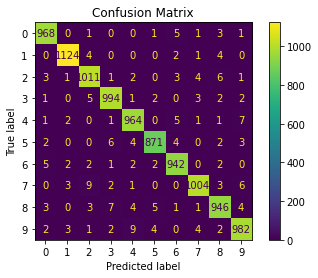

In [13]:
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [14]:
CR=classification_report(y_test,y_pred)
print("Classification report\n")
print(CR)

Classification report

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.99      0.98      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



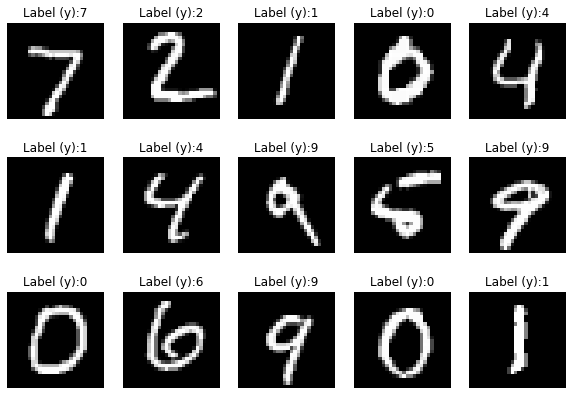

In [15]:
# PLOT OF TEST DATA ALONG WITH PREDICTED CLASS LABELS
fig=plt.figure(figsize=(10,7))
for i in range(15):
    ax=fig.add_subplot(3,5,i+1)
    ax.imshow(X_test[i].reshape(28,28),cmap=plt.get_cmap('gray'))
    ax.set_title('Label (y):{y}'.format(y=y_pred[i]))
    plt.axis('off')

In [16]:
# Visualization  of multi layer perceptron weights in hidden layer
# Looking at the learned coefficients of a neural network can provide insight into the learning behaviour.
# The input data consists 784 features in the dataset
# We have used one hidden layer with 128 neurons. Therefore weight matrix has shape (784.128)
# We can therefore visualize a single column of the weight matrix as a 28X28 pixel image.
w=mlpc.coefs_
w=np.array(w[0])
w.shape

(784, 128)

In [17]:
w1=np.array(w[:,0])
w1.shape

(784,)

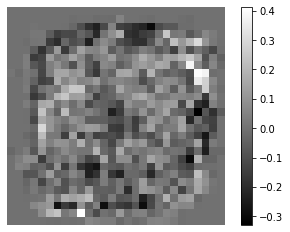

In [18]:
w_matrix=w1.reshape(28,28)
fig=plt.figure()
plt.imshow(w_matrix,cmap='gray')
plt.grid(False)
plt.axis(False)
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'Loss curve')

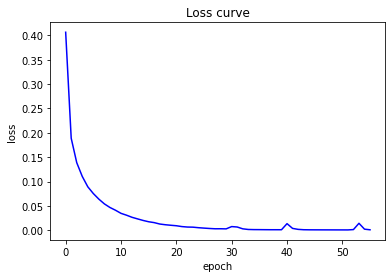

In [19]:
plt.plot(mlpc.loss_curve_,'b-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss curve')

In [20]:
# MLP REGRESSOR ON CALIFORNIA HOUSING DATASET

In [21]:
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
# MLP REGRESSOR implements a multi-layer perceptron that trains using 
# backpropagation with no activation function in the output layer. Therefore it uses the square error as the loss function,
# The output is a set of continuous values.
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_validate, ShuffleSplit

In [24]:
np.random.seed(306)
cv=ShuffleSplit(n_splits=5,test_size=0.2,random_state=42)

In [26]:
# Dataset loading - california housing dataset
import sklearn
dataset=sklearn.datasets.fetch_california_housing()
X,y=dataset.data,dataset.target

In [27]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

In [28]:
X_train.shape,X_test.shape

((16512, 8), (4128, 8))

In [29]:
# Fitting a pipeline in MLP Regressor
pipe=Pipeline([
    ('scaler',StandardScaler()),
    ('regressor',MLPRegressor(hidden_layer_sizes=(32)))
])
cv_results=cross_validate(pipe,X_train,y_train,
                         cv=cv,scoring='neg_mean_absolute_percentage_error',
                         return_train_score=True,
                         return_estimator=True,n_jobs=2)
mlp_train_error=-1*cv_results['train_score']
mlp_test_error=-1*cv_results['test_score']
print("Mean absolute error of linear regression model on train set:\n",
     f"{mlp_train_error.mean():.3f} +/- {mlp_train_error.std():.3f}")
print("Mean absolute error of linear regression model on test set:\n",
     f"{mlp_test_error.mean():.3f} +/- {mlp_test_error.std():.3f}")


Mean absolute error of linear regression model on train set:
 0.212 +/- 0.002
Mean absolute error of linear regression model on test set:
 0.212 +/- 0.006


In [30]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', MLPRegressor(hidden_layer_sizes=32))])

In [31]:
mean_absolute_percentage_error(y_train,pipe.predict(X_train))

0.20517616916407086

In [32]:
mean_absolute_percentage_error(y_test,pipe.predict(X_test))

0.2168016418688319

Text(0, 0.5, 'predicted')

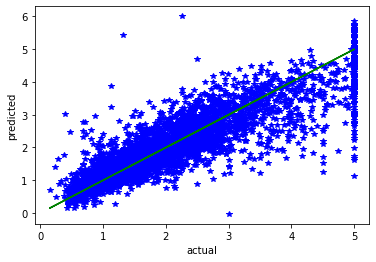

In [33]:
plt.plot(y_test,pipe.predict(X_test),'b*')
plt.plot(y_test,y_test,'g-')
plt.xlabel('actual')
plt.ylabel('predicted')